In [7]:
import numpy as np
import matplotlib.pyplot as plt

R, Z = np.meshgrid((np.linspace(0.1, 2, 129)), (np.linspace(-5, 5, 129)))

J_tor = np.exp(-(R-0.5)**2 - Z**2) * 1e3 # A/m^2
from freegs.gradshafranov import GSsparse
generator = GSsparse(np.amin(R), np.amax(R), np.amin(Z), np.amax(Z))

np.set_printoptions(precision=2)
generator(3, 3).toarray()

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.61,  0.  ,  0.04, -2.3 ,  0.04,  0.  ,  0.61,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

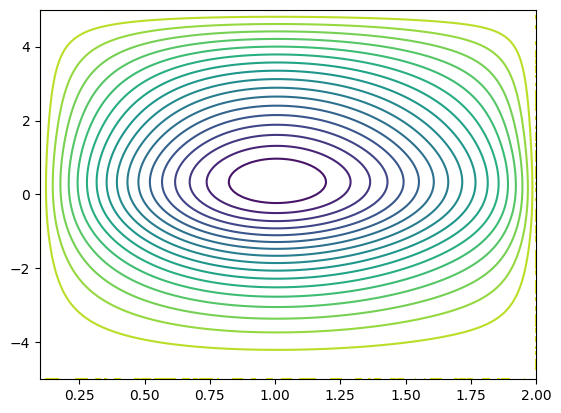

In [8]:
nx, ny = R.shape
A = generator(nx, ny)

from scipy.sparse.linalg import factorized
solver = factorized(A.tocsc())

mu0 = 4*np.pi*1e-7
rhs = mu0 * R * J_tor
rhs[0,:] = rhs[-1,:] = rhs[:,0] = rhs[:,-1] = 0
psi = solver(rhs.flatten()).reshape(R.shape)

plt.contour(R, Z, psi, 20)

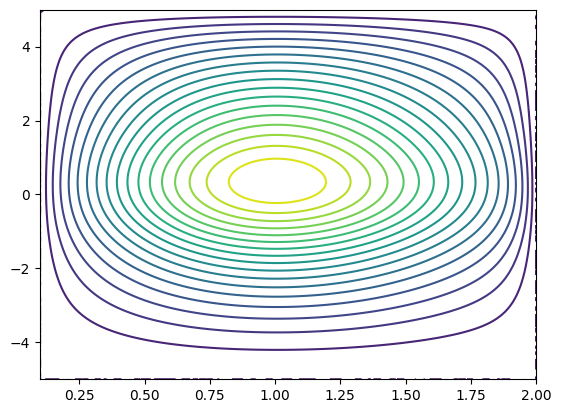

In [9]:
rhs = -mu0 * R * J_tor

# List of indices on the boundary
bndry_indices = np.concatenate(
    [
        [(x, 0) for x in range(nx)],
        [(x, ny - 1) for x in range(nx)],
        [(0, y) for y in range(ny)],
        [(nx - 1, y) for y in range(ny)],
    ]
)

from freegs.gradshafranov import Greens
from scipy.integrate import romb

dR = R[1, 0] - R[0, 0]
dZ = Z[0, 1] - Z[0, 0]

for x, y in bndry_indices:
    # Calculate the response of the boundary point
    # to each cell in the plasma domain
    greenfunc = Greens(R, Z, R[x, y], Z[x, y])

    # Prevent infinity/nan by removing (x,y) point
    greenfunc[x, y] = 0.0

    # Integrate over the domain
    rhs[x, y] = romb(romb(greenfunc * J_tor)) * dR * dZ

# Re-solve
psi = solver(rhs.flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)